In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


# Step 1: Load Data
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')



In [3]:
# Step 2: Merge Data to Create Comprehensive Dataset
# Rename columns for clarity
transactions.rename(columns={
    'Price': 'ProductPrice', 
    'ProductName': 'ProductName_transaction', 
    'Category': 'Category_transaction'
}, inplace=True)

products.rename(columns={
    'Price': 'Price_product',
    'ProductName': 'ProductName_product',
    'Category': 'Category_product'
}, inplace=True)

customers.rename(columns={
    'Region': 'CustomerRegion',
    'SignupDate': 'CustomerSignupDate'
}, inplace=True)

In [4]:
# Merge datasets
transactions = transactions.merge(products, on='ProductID', how='left')
transactions = transactions.merge(customers, on='CustomerID', how='left')

# Step 3: Create Customer Profile
customer_profile = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Total transactions
    'Quantity': 'sum',  # Total quantity purchased
    'ProductPrice': 'mean',  # Average product price
    'ProductID': lambda x: x.mode()[0]  # Most purchased product
}).reset_index()

In [5]:
# Rename columns for better understanding
customer_profile.rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TotalTransactions',
    'Quantity': 'TotalQuantity',
    'ProductPrice': 'AvgProductPrice',
    'ProductID': 'FavoriteProduct'
}, inplace=True)

In [6]:
# Convert categorical 'FavoriteProduct' into numerical features using one-hot encoding
customer_profile = pd.get_dummies(customer_profile, columns=['FavoriteProduct'], drop_first=True)

# Merge demographic data from Customers.csv
customer_profile = customer_profile.merge(customers, on='CustomerID', how='left')

# Step 4: Normalize Features
# Drop irrelevant columns and normalize features
features = customer_profile.drop(columns=['CustomerID', 'CustomerName', 'CustomerRegion', 'CustomerSignupDate'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Perform Clustering and Evaluate Metrics
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)
optimal_k = None
best_db_index = float('inf')

In [7]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Compute Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_index)
    
    # Compute Silhouette Score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Find optimal k with the lowest DB Index
    if db_index < best_db_index:
        best_db_index = db_index
        optimal_k = k

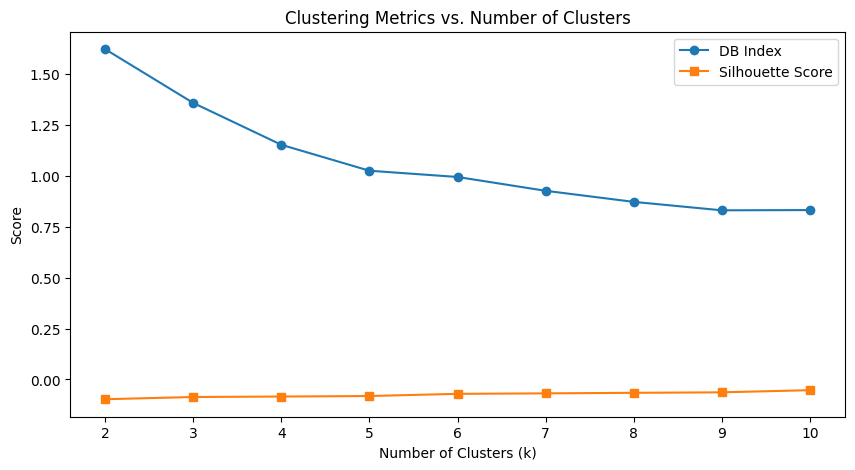

In [8]:

# Step 6: Visualize Metrics
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db_scores, marker='o', label='DB Index')
plt.plot(cluster_range, silhouette_scores, marker='s', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('Clustering Metrics vs. Number of Clusters')
plt.legend()
plt.show()


In [9]:
# Step 7: Perform Clustering with Optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_cluster_labels = final_kmeans.fit_predict(scaled_features)

# Add Cluster Labels to customer_profile
customer_profile['Cluster'] = final_cluster_labels





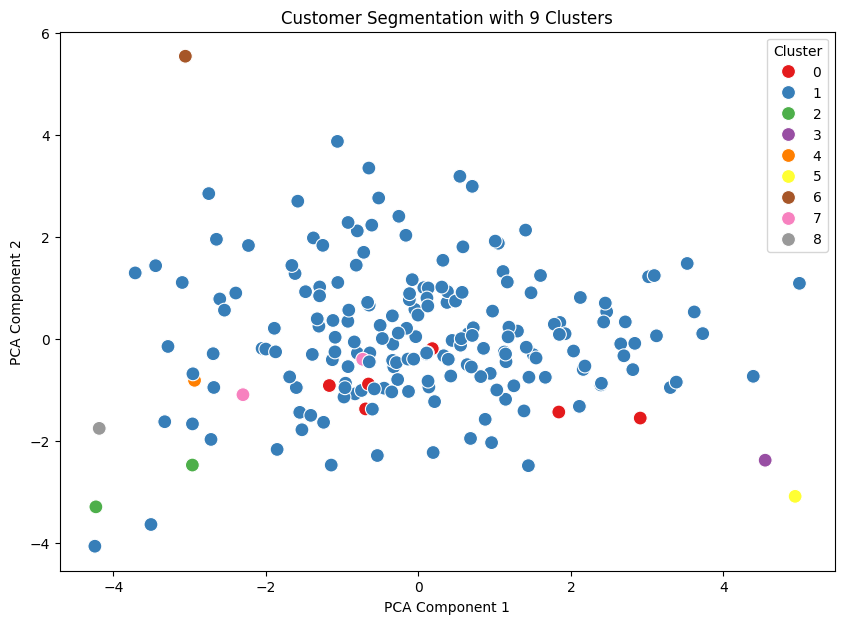

In [10]:
# Step 8: Visualize Clusters (PCA for dimensionality reduction)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_profile['Cluster'], palette='Set1', s=100)
plt.title(f'Customer Segmentation with {optimal_k} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [11]:
# Step 9: Generate Clustering Report
report = {
    'Optimal Clusters': optimal_k,
    'Best DB Index': best_db_index,
    'Silhouette Score (for optimal k)': silhouette_scores[optimal_k - 2]  # Index aligned with cluster_range
}

print('Clustering Report:')
for key, value in report.items():
    print(f'{key}: {value}')

Clustering Report:
Optimal Clusters: 9
Best DB Index: 0.830007234101864
Silhouette Score (for optimal k): -0.06297470431744642
